Load all the necessary libraries:

In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

Start off by defining some conversion functions. Each is designed to reduce the file size a bit by converting text data into only a few bits worth of numerical data.

The the data being loaded is straight from Kaggle (except the Projects.csv set, which had to be treated separately due to it's size). If you are working with files ending with `_clean` these steps are irrelevant beyond discovering how the cleaned files were created.

In [ ]:
# If the value is "Yes", convert to a 1. Otherwise, 0 (i.e "No")

def yes_no_binary_converter(x):
    return 1 if x == "Yes" else 0

def zipcode_converter(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

# For Schools.csv
def metro_type_converter(x):
    if x == 'rural':
        return 1
    if x == 'suburban':
        return 2
    if x == 'urban':
        return 3
    if x == 'town':
        return 4
    
    return 0 # if metropolitan type is ambiguous

# For Teachers.csv
def teacher_prefix_converter(x):
    if x == 'Mrs.':
        return 1
    if x == 'Mr.':
        return 2
    
    return 0 # if prefix is ambiguous

# For Projects.csv
def grade_level_converter(x):
    if '2' in x:
        return 1
    if '3' in x:
        return 2
    if '6' in x:
        return 3
    if '9' in x:
        return 4
        
    return -1 # if grade is unknown/missing

# For Projects.csv
def project_type_converter(x):
    if x == 'Professional Development':
        return 0
    if x == 'Student-Led':
        return 1
    if x == 'Teacher-Led':
        return 2
    
# For Projects.csv
def project_status_converter(x):
    if x == 'Expired':
        return 0
    if x == 'Fully Funded':
        return 1
    if x == 'Live':
        return 2

Load *Donors.csv*. Modify headers to exclude spaces. Binary conversion for whether the donor is a teacher. Ensure zip code is of integer type. Clean state column by ensuring that unmarked states are corrected based on city and zip information with a 95% confidence level

In [ ]:
donors_dat = pd.read_csv('data/Donors.csv',
                         header=0,
                         names=['donor_id', 'donor_city', 'donor_state', 'donor_teacher', 'donor_zip'],
                         na_values='other',
                         converters={'donor_zip': zipcode_converter, 'donor_teacher': yes_no_binary_converter})

In [ ]:
donors_dat.to_csv('data/data_clean/donors_clean.csv', index=False)

In [ ]:
# donor_state_null = donors_dat[(donors_dat['donor_state'].isnull()) & (donors_dat['donor_city'].notnull()) & (donors_dat['donor_zip'].notnull())]

In [ ]:
# replacements = []

# unique_donor_locals = donor_state_null.drop_duplicates(['donor_city', 'donor_zip'])

# c = 0
# l = len(unique_donor_locals)
# from datetime import datetime
# s = datetime.now()

# for row in unique_donor_locals.itertuples():
#     donor_augment = donors_dat[(donors_dat['donor_city'] == row.donor_city) & (donors_dat['donor_zip'] == row.donor_zip) & 
#               (donors_dat['donor_state'].notnull())]
#     if len(donor_augment) > 1:
#         top_approxs, top_approxs_cnt = np.unique(donor_augment['donor_state'], return_counts=True)
#         m = top_approxs_cnt.argmax()
#         if max(top_approxs_cnt) / sum(top_approxs_cnt) > 0.95:
#             replacements.append([row.donor_id, top_approxs[m]])
#     c += 1
#     if c % 50 == 0:
#         print('{:.1f}%...\t Remaining: {}'.format(c/l, (datetime.now() - s)/c))
#         break
        
# replacements

Load *Donations.csv*. Modify headers to exclude spaces. Binary conversion for whether the donation included an optional donation. Ensure timestamps are converted to integers (for easy computation of timedeltas and reverse-conversion).

In [ ]:
donations_dat = pd.read_csv('data/Donations.csv',
                         header=0,
                         names=['project_id', 'donation_id', 'donor_id', 'opt_donation', 'amount', 'cart_seq', 'date'],
                         converters={'opt_donation': yes_no_binary_converter},
                         parse_dates=['date'])

donations_dat['date'] = donations_dat['date'].apply(lambda t: int(t.timestamp()))
donations_dat.sample(5) # randomly sample 5

Load *Schools.csv*. Modify headers to exclude spaces. Conversion of metro type to numerical.

In [ ]:
schools_dat = pd.read_csv('data/Schools.csv',
                         header=0,
                         names=['school_id', 'school_name', 'metro_type', 'free_lunch', 'school_state', 'school_zip', 'school_city', 'school_county', 'school_district'],
                         converters={'metro_type': metro_type_converter})
schools_dat.sample(5) # randomly sample 5

Load *Teachers.csv*. Modify headers to exclude spaces. Conversion of teacher prefix to numerical. Dates to integer (see above).

In [ ]:
teachers_dat = pd.read_csv('data/Teachers.csv',
                           header=0,
                           names=['teacher_id', 'prefix', 'first_project_posted'],
                           parse_dates=['first_project_posted'],
                           converters={'prefix': teacher_prefix_converter})

teachers_dat['first_project_posted'] = teachers_dat['first_project_posted'].apply(lambda t: int(t.timestamp()))
teachers_dat.sample(5) # randomly sample 5

Load *Resources.csv*. Modify headers to exclude spaces. Remove any rows without `quantity` or `price`, two key variables of the dataset.

In [ ]:
resources_dat = pd.read_csv('data/Resources.csv',
                           header=0,
                           names=['project_id', 'resource', 'quantity', 'price', 'vendor'])

resources_dat = resources_dat.dropna(axis=0, subset=['quantity', 'price'])
resources_dat.sample(5) # randomly sample 5

Load two partitions of *Projects.csv* (previously split, code not included here). Conversion of text to integer (see above). Date values either remain null or are converted to integer (see above).

In [ ]:
# LARGE FILE!
projects_textonly_dat = pd.read_csv('data/Projects_textonly.csv', index_col=0)
projects_textonly_dat.sample(5) # randomly sample 5

In [ ]:
# LARGE FILE!
projects_notext_dat = pd.read_csv('data/Projects_notext.csv', parse_dates=['posted', 'expire', 'funded'],
                                 converters={'proj_type': project_type_converter,
                                             'grade_level': grade_level_converter,
                                             'status': project_status_converter})

projects_notext_dat['posted'] = projects_notext_dat['posted'].apply(lambda t: np.nan if pd.isnull(t) else int(t.timestamp()))
projects_notext_dat['expire'] = projects_notext_dat['expire'].apply(lambda t: np.nan if pd.isnull(t) else int(t.timestamp()))
projects_notext_dat['funded'] = projects_notext_dat['funded'].apply(lambda t: np.nan if pd.isnull(t) else int(t.timestamp()))
projects_notext_dat.sample(5) # randomly sample 5

# Reload

In [2]:
donors_dat = pd.read_csv('data/data_clean/donors_clean.csv')
donations_dat = pd.read_csv('data/data_clean/donations_clean.csv')
schools_dat = pd.read_csv('data/data_clean/schools_clean.csv')
teachers_dat = pd.read_csv('data/data_clean/teachers_clean.csv')
resources_dat = pd.read_csv('data/data_clean/resources_clean.csv')
projects_notext_dat = pd.read_csv('data/data_clean/projects_num_clean.csv')

# Dataset Subsetting

From the last year of donation data: 9 May 2017 - 9 May 2018

Format: `(% of original dataset, # of total entries)`

In [3]:
last_years_donations = Timestamp(donations_dat['date'].max(), unit='s') - pd.DateOffset(years=1)

#timestamp (sec) of one year prior to most recent donation
last_years_donations_sec = int(last_years_donations.timestamp()) 

In [4]:
donations_subset = donations_dat[donations_dat['date'] > last_years_donations_sec]
unique_donations_subset = donations_subset.drop_duplicates('donor_id')
len(donations_subset) / len(donations_dat), len(donations_subset)

(0.2662655475263466, 1248222)

In [5]:
donors_subset = donors_dat[donors_dat['donor_id'].isin(unique_donations_subset['donor_id'])]
len(donors_subset) / len(donors_dat), len(donors_subset)

(0.2764618588173218, 586829)

In [6]:
projects_subset = projects_notext_dat[projects_notext_dat['project_id'].isin(donations_subset['project_id'])]
len(projects_subset) / len(projects_notext_dat), len(projects_subset)

(0.2117445104069809, 222030)

In [7]:
teachers_subset = teachers_dat[teachers_dat['teacher_id'].isin(projects_subset['teacher_id'])]
len(teachers_subset) / len(teachers_dat), len(teachers_subset)

(0.3014296351451973, 121446)

In [8]:
schools_subset = schools_dat[schools_dat['school_id'].isin(projects_subset['school_id'])]
len(schools_subset) / len(schools_dat), len(schools_subset)

(0.5803570205362159, 42362)

In [9]:
resources_subset = resources_dat[resources_dat['project_id'].isin(projects_subset['project_id'])]
len(resources_subset) / len(resources_dat), len(resources_subset)

(0.19849332102815756, 1426400)

# Donors: Who are they?

The goal is to garner the most donations. So, who should our emails be targeting?

In [10]:
unique_donors = donations_subset.groupby('donor_id')
donors_donation_counts = pd.DataFrame({
    'total_amount': unique_donors['amount'].sum(), 
    'count': unique_donors['amount'].count()
    })
donors_donation_counts['avg'] = donors_donation_counts['total_amount'] / donors_donation_counts['count']
unique_donors_complete = donors_subset.merge(donors_donation_counts, right_index=True, left_on='donor_id')
unique_donors_complete.sample(5)

,donor_id,donor_city,donor_state,donor_teacher,donor_zip,count,total_amount,avg
604239,48d435d68efacc170285beb9cd41dc4b,Medford,Massachusetts,1,21.0,11,209.09,19.008182
680586,5208728d22a00a425d41c6e8b71aba03,Saint Louis,Missouri,0,631.0,3,75.00,25.000000
1411855,aa365a4cd585300000772327d5c4d438,Kinston,North Carolina,0,285.0,2,309.47,154.735000
304021,249cebb985285c9547dc36bfa1c332c8,Dallas,Texas,0,752.0,1,25.00,25.000000
2074862,fa3d31a02eed9be866b2b08d1382ba92,Ventura,California,0,930.0,1,50.00,50.000000


### How much do people donate?

How does donation frequency compare to donation amounts? Use custom bins.

In [11]:
donate_freq_bins = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 50, 100, 200, 500, 1000, 5000, 10000])

In [12]:
unique_donors_complete['bin'] = np.digitize(unique_donors_complete['count'], donate_freq_bins, right=True)
donation_freq = np.unique(unique_donors_complete['bin'], return_counts=True)

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


'24.84% with 2+ donations'

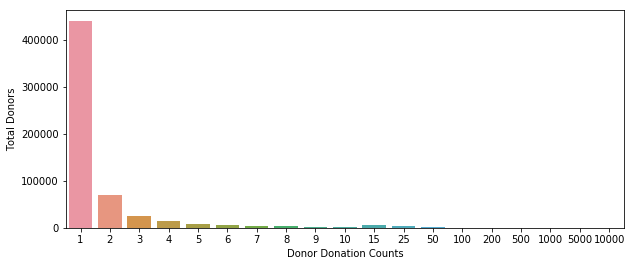

In [13]:
plt.subplots(figsize=(10, 4))
sns.barplot(x=donate_freq_bins, y=donation_freq[1])
plt.xlabel('Donor Donation Counts')
plt.ylabel('Total Donors')
t = sum(donation_freq[1])
'{:.2f}% with 2+ donations'.format(100 * (t - donation_freq[1][0]) / t)

**Only a quarter of all donors donate more than one time.**

In [14]:
print('Descending Average Donation')
print(unique_donors_complete.sort_values('avg', ascending=False)[:10])
print('Mean/median: {}/{}'.format(round(np.mean(unique_donors_complete['avg'])), round(np.median(unique_donors_complete['avg']))))

print('\nDescending Donations Total Amount')
print(unique_donors_complete.sort_values('total_amount', ascending=False)[:10])
print('Mean/median: {}/{}'.format(round(np.mean(unique_donors_complete['total_amount'])), round(np.median(unique_donors_complete['total_amount']))))

print('\nDescending Donation Count')
print(unique_donors_complete.sort_values('count', ascending=False)[:10])
print('Mean/median: {}/{}'.format(round(np.mean(unique_donors_complete['count'])), round(np.median(unique_donors_complete['count']))))

Descending Average Donation
                                 donor_id    donor_city  donor_state  \
1502224  b51a1b79ce091021e909fde33c5e5810   El Sobrante   California   
103766   0c796f4db2c7adc93db6969153616cdc     Ridgeland  Mississippi   
596512   47e50d951a655979e520f8e5e01a7212    Maineville          NaN   
1954691  ebb56c8b81859e95c817c941377a98f1   Rogersville          NaN   
434295   345470c95caa44fd8c5c129075367669    Chatsworth   California   
145692   1185f4869739d6484525e074c58e5dee      Carthage     Missouri   
991473   7779c0b3af936b7f8f6953f06882c094     Rochester     New York   
421007   32bbf59291ea50ff7ea998661efbc281       Elkhart      Indiana   
1817130  db1ea4fc95f8d657958a178029a8a203  Indianapolis      Indiana   
338592   28c9d442944bd79246915a51da6d805a       Chicago     Illinois   

         donor_teacher  donor_zip  count  total_amount        avg  bin  
1502224              0      948.0      1      25000.00  25000.000    0  
103766               1      391.0

**I've calculated the average donation (AD) amount for each donor (total donation amount (\$) / total number of donations). The top 10 donors by AD donate very infrequently, mostly only once. Some of these high AD donors are teachers. Donors with the highest total donation amount have donated many times (300-1,400 times). Donors with a very high donation frequency donate between 1,400-7,600 times. Some are teachers. Their AD is low (only a few dollars).**

Only 25% of donors donate more than once.

Most donors only donate once, some two or three times, and some up to 8,000 times. Most donors have donated a total of \$50, some more than \$100,000 in total. The median donation is \$38, the mean is \$58.

How does the total amount that a donor has given compare to the total number of donations they've made?

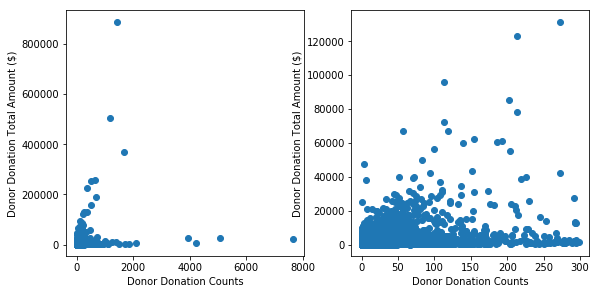

In [20]:
plt.subplots(figsize=(8,4))
plt.tight_layout()
plt.subplot(121)
plt.scatter(unique_donors_complete['count'], unique_donors_complete['total_amount'])
plt.xlabel('Donor Donation Counts')
plt.ylabel('Donor Donation Total Amount ($)');

plt.subplot(122)
focal_donors = unique_donors_complete[unique_donors_complete['count'] < 300]
plt.scatter(focal_donors['count'], focal_donors['total_amount'])
plt.xlabel('Donor Donation Counts')
plt.ylabel('Donor Donation Total Amount ($)');

**Scatter plots of individual donors, showing the relationship of the number of times they've donated to their total donation amount. The right plot excludes donors who've donated more than 300 times. Very high density of donors in that 1-100 donations range, with total amount between \$1-20,000.**

Median Average Donation for each Donation Count Bin

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


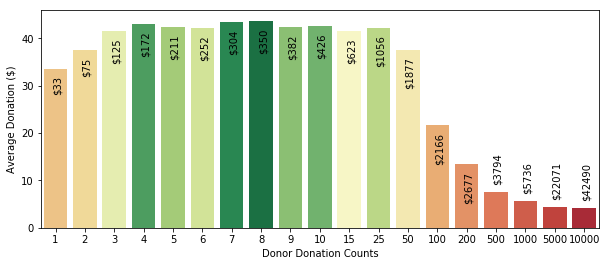

In [21]:
donation_count_avgs = unique_donors_complete.groupby('bin')['avg'].quantile(.5)
plt.subplots(figsize=(10, 4))

values = donation_count_avgs.values

mult = values * donate_freq_bins

pal = sns.color_palette("RdYlGn_r", len(values))
rank = values.argsort().argsort()

sns.barplot(x=donate_freq_bins, y=values, palette=np.array(pal[::-1])[rank])

plt.xlabel('Donor Donation Counts')
plt.ylabel('Average Donation ($)');

for x in range(len(donate_freq_bins)):
    v = donation_count_avgs.values[x]
    
    a='bottom'
    o = 1.5
    
    if v > 12:
        a = 'top'
        o = -1.5        
    plt.text(-0.1+x, donation_count_avgs.values[x] + o, '$'+str(int(mult[x])), rotation=90, va=a)

**Donors binned by how many times they've donated (with 51-100 binned into 100, etc.). On the *y*-axis is the median AD for that group of donors (also represented by color, red is a low median AD, green is high). The text annotations denote the estimated total donation money from that group of donors (bin $\times$ median AD).**

A donor moving up to the next donation count bin would account for how much of an increase in median average donation?

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


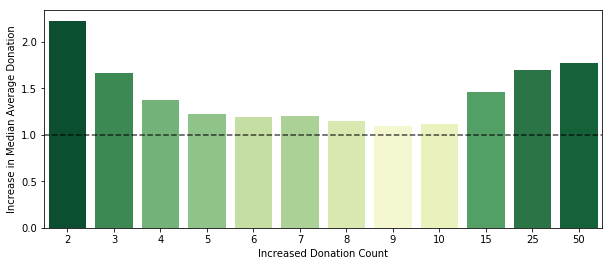

In [75]:
plt.subplots(figsize=(10, 4))
inc = mult[1:] / mult[:-1]

up_to = 12

pal = sns.color_palette("YlGn_r", up_to)
rank = inc[:up_to].argsort().argsort()

sns.barplot(x=donate_freq_bins[1:up_to+1], y=inc[:up_to], palette=np.array(pal[::-1])[rank])
plt.ylabel('Increase in Median Average Donation')
plt.xlabel('Increased Donation Count');
plt.axhline(1, 0, 1, linestyle='--', c='k', alpha=0.7)

**This plot attempts to show how much the median AD increases if a donor moves from bin x to bin x+1. For example, if a donor donates one more time after having only donated once, they join the twice donated group of donors. This new group's median AD is just over 2 times larger than the median AD of the once donated group of donors. Again, the median AD of donors who've donated 9 times is only *slightly* larger than the median AD of donors who've donated 8 times.**

**Based on this, we can say that it's more valuable to get a one time donor to donate a second time than it is to get an eight time donor to donate a nineth time**

A jump from a one-time donor to a two-time donor is the most significant, reasonable increase. The median average donation is likely to increase more than two-fold.

Which group of frequencies has the highest average donation per donor?

In [23]:
binned = unique_donors_complete.groupby('bin')
freq_described = binned.describe()['avg']
print('Top five donation frequencies by mean average donation amount:')
print(donate_freq_bins[freq_described.nlargest(5, 'mean').index])
print(freq_described.nlargest(5, 'mean')['mean'].values)
print('\nTop five donation frequencies by 25% quantile average donation amount:')
print(donate_freq_bins[freq_described.nlargest(5, '25%').index])
print(freq_described.nlargest(5, '25%')['25%'].values)
print('\nTop five donation frequencies by 50% quantile average donation amount:')
print(donate_freq_bins[freq_described.nlargest(5, '50%').index])
print(freq_described.nlargest(5, '50%')['50%'].values)
print('\nTop five donation frequencies by 75% quantile average donation amount:')
print(donate_freq_bins[freq_described.nlargest(5, '75%').index])
print(freq_described.nlargest(5, '75%')['75%'].values)

Top five donation frequencies by mean average donation amount:
[5000   50   25  100    8]
[ 87.89302151  74.38347853  72.66522506  70.85511394  68.0467961 ]

Top five donation frequencies by 25% quantile average donation amount:
[ 7  8  9 10  6]
[ 29.28571429  28.75        28.33333333  27.7         27.5       ]

Top five donation frequencies by 50% quantile average donation amount:
[ 8  7  4 10  9]
[ 43.75        43.42857143  43.07        42.6         42.47777778]

Top five donation frequencies by 75% quantile average donation amount:
[ 50 100  25   3   4]
[ 94.90456294  77.44613818  74.94684783  73.33333333  71.536875  ]


What kind of outliers exist in the set? Is it reasonable for donors to have given more than 365 times with their average donation exceeding \$5 per donation? 47 donors fall under this category. Do we keep them?

In [24]:
excessive_amount_donors = unique_donors_complete[(unique_donors_complete['avg'] > 5) &
                                                 (unique_donors_complete['count'] > 365)]
print(len(excessive_amount_donors))

47


Do people actually donate \$5,600-25,000 in a single online transaction? Are there actually individuals who have donated a cumulative \$130,000-900,000 over 370-1,400 donations? Are there actually individuals who have donated more than 1,400 times? Are these scenarios realistic, or do they show an underlying pattern that is confounding our perspective on high/frequent donors?

Let's look at high frequency donors. Since 7,651 donations in one year is roughly 21 donations a day, we'd like to make sure that's a realistic looking entry.

In [25]:
high_freq_donor_ids = unique_donors_complete.sort_values('count', ascending=False)['donor_id'][:10]
total_donations_count = sum(unique_donors_complete.sort_values('count', ascending=False)[:10]['count'])
'Total # of donations for top 10 donors by donation count: {}'.format(total_donations_count)

'Total # of donations for top 10 donors by donation count: 31211'

In [26]:
high_freq_projects = donations_subset[donations_subset['donor_id'].isin(high_freq_donor_ids)].drop_duplicates('project_id')
print('# of unique projects for top 10 donors by donation count: {}'.format(len(high_freq_projects)))

# of unique projects for top 10 donors by donation count: 8378


http://www.ipl.org/div/stateknow/popchart.html

## Geography

### Proportion of unique donors to state population

Null hypothesis: Each state has the same proportion of donors to state population.

If we reject this ($p<0.05$), we have proof that one or more states is significantly different from other states with regards to number of unique donors.

In [27]:
states_pop = pd.read_table('data/statepop.txt', names=['state', 'population'])

In [28]:
unique_donors_per_state = unique_donors_complete.groupby('donor_state').size()
unique_donors_per_state = pd.DataFrame(unique_donors_per_state, columns=['donors']).reset_index()

p-value: 1.0


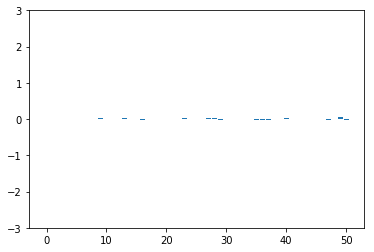

In [29]:
donor_states_pop = states_pop.merge(unique_donors_per_state, right_on='donor_state', left_on='state')
donor_states_pop.loc[:, 'ratio'] = donor_states_pop['donors'] / donor_states_pop['population']

fo = donor_states_pop['ratio']
fe = donor_states_pop['ratio'].mean()
print('p-value: {}'.format(st.chisquare(fo).pvalue))
residuals = (fo-fe)/ np.sqrt(fe)
plt.bar(range(len(residuals)), residuals)

plt.ylim([-3,3]);

We do not reject the null ($p=1.0$). States have no preference for number of donors per.

### Proportion of donation amount per person to states

Null: Each state has about the same proportion of donation money per person.

In [30]:
total_donated_per_state = unique_donors_complete.groupby('donor_state')['total_amount'].sum()
total_donated_per_state = pd.DataFrame(total_donated_per_state, columns=['total_amount']).reset_index()

p-value: 1.0


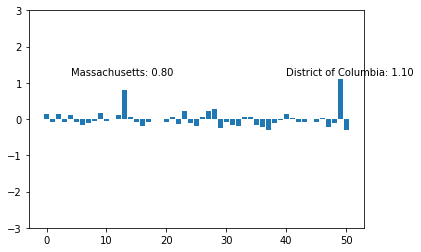

In [31]:
donor_states_amt = states_pop.merge(total_donated_per_state, right_on='donor_state', left_on='state').drop('donor_state', axis=1)
donor_states_amt.loc[:, 'ratio'] = donor_states_amt['total_amount'] / donor_states_amt['population']

fo = donor_states_amt['ratio']
fe = donor_states_amt['ratio'].mean()
print('p-value: {}'.format(st.chisquare(fo).pvalue))
residuals = (fo-fe)/ np.sqrt(fe)
plt.bar(range(len(residuals)), residuals)

plt.ylim([-3,3])

outliers = residuals[np.absolute(residuals) > 0.5].index
for outlier in outliers:
    l = '{}: {:.2f}'.format(donor_states_amt.loc[outlier, 'state'], residuals[outlier])
    plt.annotate(l, xy=(outlier-9, 1.2))

Each state has about the same amount in donations coming from donors, however the amount being donated does vary more than the number of donators per state. In fact, Massachusetts and D.C seem to have more coming from an individuals than other states.

In [32]:
# donor_habits = []
# c = 0
# completed = []
# for donor in donations_subset['donor_id']:
    
#     if donor in completed:
#         continue
#     else:
#         completed.append(donor)
        
#     donations = donations_subset.loc[donations_subset['donor_id'] == donor, ['project_id', 'amount', 'date']].sort_values('date')
    
#     donations_spread = np.median(donations.iloc[1:, 2].values - donations.iloc[:-1, 2].values)
#     donations_amount = np.median(donations.iloc[1:, 2].values - donations.iloc[:-1, 2].values)
    
#     donor_habits.append([len(donations), 
#                          len(np.unique(donations['project_id']))
#                          , donations_spread])
    
#     if (c+1) % 25 == 0:
#         break
#     c += 1 
# donor_habits = pd.DataFrame(donor_habits, columns=['total_donations', 'total_projects', 'donations_spread'])

/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
donations_donor_count = donations_subset.groupby('donor_id').size()

i = donations_donor_count[donations_donor_count == 2].index

t = donations_subset[donations_subset['donor_id'].isin(i)].groupby('donor_id')

In [34]:
# 0: 1st donation amount, 1: 2nd donation amount
coupled_donation_amounts = []
ids = []
c = 0
for row in t:
    s_row = row[1].sort_values('date')
    diff = s_row['date'].values[1] - s_row['date'].values[0]
    
    if diff > 60 * 60 * 24:
        
        v = s_row['amount'].values
        if max(v) < 300:
            coupled_donation_amounts.append(v)
            ids.append(row[0])
    
coupled_donation_amounts = np.array(coupled_donation_amounts)
ids = np.array(ids)

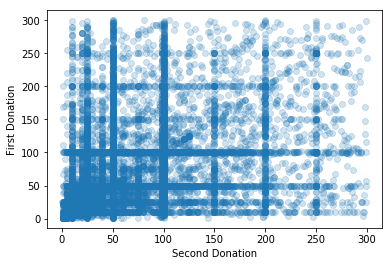

In [35]:
plt.scatter(coupled_donation_amounts[:, 0], coupled_donation_amounts[:, 1], alpha=0.2)
plt.ylabel('First Donation')
plt.xlabel('Second Donation');

**This scatter plot shows people who have donated only twice, with more than a day between donations, without donating more than \$300 in any one donation. The bottom right of the graph is of particular interest because those donors donate only a little the first time and then donate a lot more the second time.**

States with the greatest ratio of donors with 2-10 donations to donors with 1 donation.

In [36]:
one_donors = unique_donors_complete.loc[unique_donors_complete['count'] == 1, 'donor_state']
o_states, o_states_count = np.unique(one_donors[one_donors.notnull()], return_counts=True)

two_to_ten_donors = unique_donors_complete.loc[(unique_donors_complete['count'] >= 2) & (unique_donors_complete['count'] <= 25), 'donor_state']
ttt_states, ttt_states_count = np.unique(two_to_ten_donors[two_to_ten_donors.notnull()], return_counts=True)
pd.DataFrame({'state': ttt_states, 'ratio': ttt_states_count/o_states_count}).sort_values('ratio', ascending=False)

,ratio,state
1,0.362245,Alaska
11,0.353528,Hawaii
36,0.351841,Oklahoma
40,0.340500,South Carolina
28,0.336650,Nevada
8,0.335921,District of Columbia
4,0.335132,California
37,0.332497,Oregon
33,0.326060,North Carolina
47,0.324217,Washington


**The states at the top have a higher proportion of multi-donors to single donors. Why?**

### Political Leanings and Donations

In [37]:
elections_2014 = pd.read_csv('data/data_clean/2014elections_clean.csv', index_col='state')

In [38]:
s = elections_2014.sum(axis=1)
elections_2014['democrat_prob'] = elections_2014['democrat'] / s
elections_2014['republican_prob'] = elections_2014['republican'] / s
elections_2014['third_prob'] = elections_2014['third'] / s

donor_states_politcal = donor_states_amt.merge(elections_2014.drop(['democrat', 'republican', 'third'], axis=1), right_index=True, left_on='state')

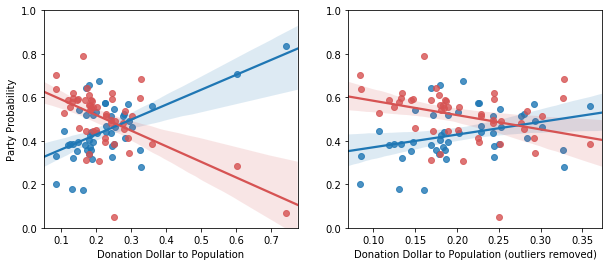

In [39]:
plt.subplots(figsize=(10,4))
plt.subplot(121)
sns.regplot('ratio', 'democrat_prob', data=donor_states_politcal)
sns.regplot('ratio', 'republican_prob', data=donor_states_politcal, color='#D65353')

plt.ylabel('Party Probability')
plt.xlabel('Donation Dollar to Population')
plt.ylim([0,1]);

plt.subplot(122)
sns.regplot('ratio', 'democrat_prob', data=donor_states_politcal[donor_states_politcal['ratio'] < 0.5])
sns.regplot('ratio', 'republican_prob', data=donor_states_politcal[donor_states_politcal['ratio'] < 0.5], color='#D65353')

plt.ylabel('')
plt.xlabel('Donation Dollar to Population (outliers removed)')
plt.ylim([0,1]);

**These regression plots attempt to shed light on any particular pattern of voting behavior and total donations. It appears as though states whose population has a high chance of voting Democrat, have a higher donation dollar per individual ratio.**

Null: There does not exist a difference in donation amount : population ratios between Democratic and Republican states.

In [141]:
def exact_mc_perm_test(xs, ys, nmc):
    n, k = len(xs), 0
    diff = np.abs(xs.mean() - ys.mean())
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(zs[:n].mean() - zs[n:].mean())
    return k / nmc

'pvalue: 0.002'

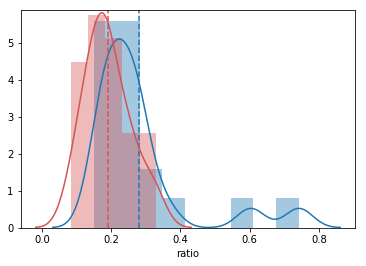

In [145]:
a = donor_states_politcal.loc[donor_states_politcal['democrat_prob'] > donor_states_politcal['republican_prob'], 'ratio']
b = donor_states_politcal.loc[donor_states_politcal['republican_prob'] > donor_states_politcal['democrat_prob'], 'ratio']

sns.distplot(a)
plt.axvline(a.mean(), 0, 1, linestyle='--')
sns.distplot(b, color='#D65353')
plt.axvline(b.mean(), 0, 1, c='#D65353', linestyle='--')
'pvalue: {:.3f}'.format(exact_mc_perm_test(a, b, 100000))

**Democratic and Republican states do not donate equal amounts. The above non-parametric permutation test supports the argument that there is a statistically significant difference in the amount donated per individual in a Dmeocratic state compared to a Reublican state (p < 0.01).**

Correlation with Household Income

In [ ]:
# zipcodetaxes = pd.read_csv('data/tax.csv')[['agi_stub', 'zipcode', 'N1', 'A00100', 'N19700', 'A19700']]

In [ ]:
# zipcodetaxes[zipcodetaxes['zipcode'] == 92037] #/100).astype('int')

In [ ]:
# round(a['A00100'].values.mean()), round(np.average(a['A00100'].values, weights=a['N1'].values))

We examine donations with a minimum number of minutes $\alpha$ between them, for all donors with exactly $\beta$ number of donations. For $\beta=4$ and $\alpha$ ranging from 30 seconds to 20 minutes, we see there is always a decreasing amount of time between donations as the the donation ordinal increases.

In [158]:
# number of donations per donor
beta = 4

a = donations_subset.groupby('donor_id').size()
i = a[a == beta].index

# subset the donations set by only keeping donations that are made by donors with beta donations
t = donations_subset[donations_subset['donor_id'].isin(i)].groupby('donor_id')

In [159]:
c = 0

gaps = []

# get the donations of each donor in the subset
for row in t:
    
    # sort the donor's donations by date
    s_row = row[1].sort_values('date')
    
    # find the differences in time between each donation
    diffs = s_row['date'].values[1:] - s_row['date'].values[:-1]
    
    # record the time differences in seconds
    gaps.append(diffs / (60 * 60 * 24))
    
    # only run through the first 100,0000 donors
    c += 1
    if c % 100000 == 0:
        break

gaps = np.array(gaps)

In [176]:
res = []

# test over various time thresholds (in hours)
for threshold in [1, 2, 6, 12, 24, 48, 72, 96, 120, 144, 168]:

    # record the median time between donations, for gaps greater than the threshold
    # for each donation transition (1st donation to 2nd, 2nd to 3rd, etc.)
    for d in range(beta-1):
        
        # first column: threshold, second: median gap, third: donation ordinal
        res.append([threshold, np.median(gaps[gaps[:, d] >= (threshold/(60*60))]), d])
        
res = np.array(res)

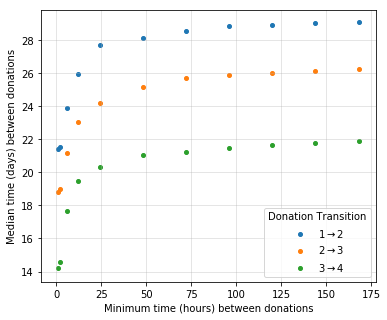

In [177]:
plt.subplots(figsize=(6,5))
plt.grid(True, alpha=0.4)

# plot scatters for each donation transition
for d in range(beta-1):
    mask = res[:, 2] == d
    plt.scatter(res[mask, 0], res[mask, 1], label=r'{}$\rightarrow${}'.format(d+1, d+2), s=16)
    
plt.xlabel('Minimum time (hours) between donations')
plt.ylabel('Median time (days) between donations')
plt.legend(title='Donation Transition');

**This graph shows the median amount of time between donations from donors, given a restriction on the minimum amount of time between donations. From this, we may target emails at precise times to donors who have already donated at least once. For example, if a person has donated three times, when is the best time to email them for their next donation? Assuming that their previous donation was at least 48 hours after the one before that (a good sign that the donor left the website and came back at another time), the site should email them about 21 days after their third donation in order to try and elicit a fourth donation.**

## Donations by Teachers

Are teachers more likely to give more money? to donate to a wider variety of projects? to have more donations? What is the difference in total amount donated by teachers compared to nonteachers?

Apply Welch's t-Test to determine if teachers donate the same number of times as non-teachers.

Null hypothesis: The populations of teachers and non-teachers are equivalent with regard to the number of times each donates.

In [50]:
donor_teacher_count_dist = [unique_donors_complete.loc[unique_donors_complete['donor_teacher'] == 0, 'count'].values,
unique_donors_complete.loc[unique_donors_complete['donor_teacher'] == 1, 'count'].values]

ttest = st.ttest_ind(donor_teacher_count_dist[0], donor_teacher_count_dist[1], equal_var=False)
if ttest.pvalue > 0.01:
    print('Reject the null. One population is greater or equal.')
else:
    print('Cannot reject the null. The populations are equivalent.')

Cannot reject the null. The populations are equivalent.


We do the same test for the average amount donated.

In [51]:
donor_teacher_avg_dist = [unique_donors_complete.loc[unique_donors_complete['donor_teacher'] == 0, 'avg'].values,
unique_donors_complete.loc[unique_donors_complete['donor_teacher'] == 1, 'avg'].values]

ttest = st.ttest_ind(donor_teacher_avg_dist[0], donor_teacher_avg_dist[1], equal_var=False)
print(ttest.pvalue)
if ttest.pvalue > 0.01:
    print('Reject the null. One population is greater or equal.')
else:
    print('Cannot reject the null. The populations are equivalent.')

1.76295023688e-05
Cannot reject the null. The populations are equivalent.


Another test to see if the total amount donated for teachers and nonteachers is equivalent.

In [52]:
donor_teacher_amt_dist = [unique_donors_complete.loc[unique_donors_complete['donor_teacher'] == 0, 'total_amount'].values,
unique_donors_complete.loc[unique_donors_complete['donor_teacher'] == 1, 'total_amount'].values]

ttest = st.ttest_ind(donor_teacher_amt_dist[0], donor_teacher_amt_dist[1], equal_var=False)
print(ttest.pvalue)
if ttest.pvalue > 0.01:
    print('Reject the null. One population is greater or equal.')
else:
    print('Cannot reject the null. The populations are equivalent.')

2.39936253912e-163
Cannot reject the null. The populations are equivalent.


In [53]:
donor_teacher_amt_med = unique_donors_complete.groupby('donor_teacher')['total_amount'].quantile(0.5)
donor_teacher_avg_med = unique_donors_complete.groupby('donor_teacher')['avg'].quantile(0.5)
diffs = (donor_teacher_amt_med[1] - donor_teacher_amt_med[0],
        donor_teacher_avg_med[1] - donor_teacher_avg_med[0])

print('In their lifetime, the median total donation amount of teachers is ${:.2f} {} than non-teachers'.format(np.absolute(diffs[0]), 'less' if diffs[0] < 0 else 'more'))
print('The median average donation from teachers is ${:.2f} {} than non-teachers'.format(np.absolute(diffs[1]), 'less' if diffs[1] < 0 else 'more'))

In their lifetime, the median total donation amount of teachers is $50.00 more than non-teachers
The median average donation from teachers is $2.62 less than non-teachers


**Teachers are not statistically different in terms of the number of donations, average donation amount, or total donation amount compared to non-teachers. However, the median total donation amount is \$50 for teachers, and their median AD is \$2.62 less than non-teachers. This may imply that teachers donate more over time in smaller amounts than non-teachers.**

## Types of Projects for Donors

What is the relationship between donors and projects?

In [54]:
donations_projects = donations_subset[['project_id', 'donor_id', 'amount', 'date']].merge(donors_subset, on='donor_id')
full_project_donations = projects_subset.merge(donations_projects, on='project_id')

In [63]:
subcat_tree_median = full_project_donations.groupby('subcat_tree')['amount'].quantile(0.5)
subcat_tree_median.nlargest(20)

subcat_tree
Social Sciences, Team Sports                  940.36
Economics, Health & Life Science              598.26
Civics & Government, Foreign Languages        166.31
Financial Literacy, Health & Life Science     147.15
Special Needs, Warmth, Care & Hunger          135.79
Economics, Performing Arts                    110.21
Foreign Languages, Health & Life Science       99.00
Foreign Languages, Team Sports                 95.00
Early Development, Warmth, Care & Hunger       74.50
ESL, Economics                                 68.23
Financial Literacy, Parent Involvement         67.00
Financial Literacy, Gym & Fitness              62.50
Literacy, Warmth, Care & Hunger                59.22
Music, Nutrition Education                     52.77
Applied Sciences, Foreign Languages            50.00
Character Education, Environmental Science     50.00
Character Education, Team Sports               50.00
Civics & Government, College & Career Prep     50.00
Civics & Government, Extracurricul

# Explore

What are the unique resources a project can be categorized with? From docs:

> **Project Resource Category:** The types of items being requested by a teacher. There were five resource categories prior to October 10, 2017. After this date, there are fourteen. Prior to October 10, 2017, these categories were selected by teachers during project creation. After October 10, 2017, these categories were predicted via algorithm at roughly 95% accuracy.

In [ ]:
projects_notext_dat['resource_cat'].unique()

What are the unique categories and subcategories a project may be tagged as? From docs:

> **Project Subject Category Tree:** Every project can have either one or two subject categories. This is a comma-separated list of those subject categories.

> **Project Subject Subcategory Tree:** For every project subject category, there is also a project subject subcategory that contains greater specificity.

In [ ]:
cats = []
for cat in projects_notext_dat['cat_tree'].unique():
    if type(cat) is str:
        for c in cat.split(', '):
            cats.append(c)
        
np.unique(cats)

In [ ]:
cats = []
for cat in projects_notext_dat['subcat_tree'].unique():
    if type(cat) is str:
        for c in cat.split(', '):
            cats.append(c)
        
np.unique(cats)

## Merging Donors to Donations to Projects to Schools

In [56]:
# HEAVY MERGE
project_schools = projects_subset[['project_id', 'school_id']].merge(schools_subset[['school_id', 'school_state', 'school_city', 'school_zip']])

donations_schools = donations_subset.merge(project_schools).drop(['opt_donation', 'cart_seq'], axis=1)

donors_schools = donations_schools.merge(donors_subset, on='donor_id')

In [57]:
state_donor_transfer_mat = donors_schools.groupby(['school_state', 'donor_state']).size().unstack(fill_value=0)
# every entry M_xy is the # of donations from donor state x to school state y

In [58]:
state_donation_transfer_mat = donors_schools.groupby(['school_state', 'donor_state'])['amount'].sum().unstack(fill_value=0)
# every entry M_xy is the total donation $$ from state x to school state y

In [59]:
z_i = np.ones(state_donor_transfer_mat.shape) - np.diag(np.ones(len(state_donor_transfer_mat)))

S1 = state_donor_transfer_mat.as_matrix() * z_i

to_sum1 = S1.sum(axis=1)
from_sum1 = S1.sum(axis=0)
r1 = to_sum1 / from_sum1 # ratio of donations to state x to donations from state y

S2 = state_donation_transfer_mat * z_i
to_sum2 = S2.sum(axis=1)
from_sum2 = S2.sum(axis=0)
r2 = to_sum2 / from_sum2 # ratio of donations to state x to donations from state y

With
$$r=\frac{\text{donors to state}}{\text{donors from state}}$$
we have the most charitable states based on the number of donors to/from:

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


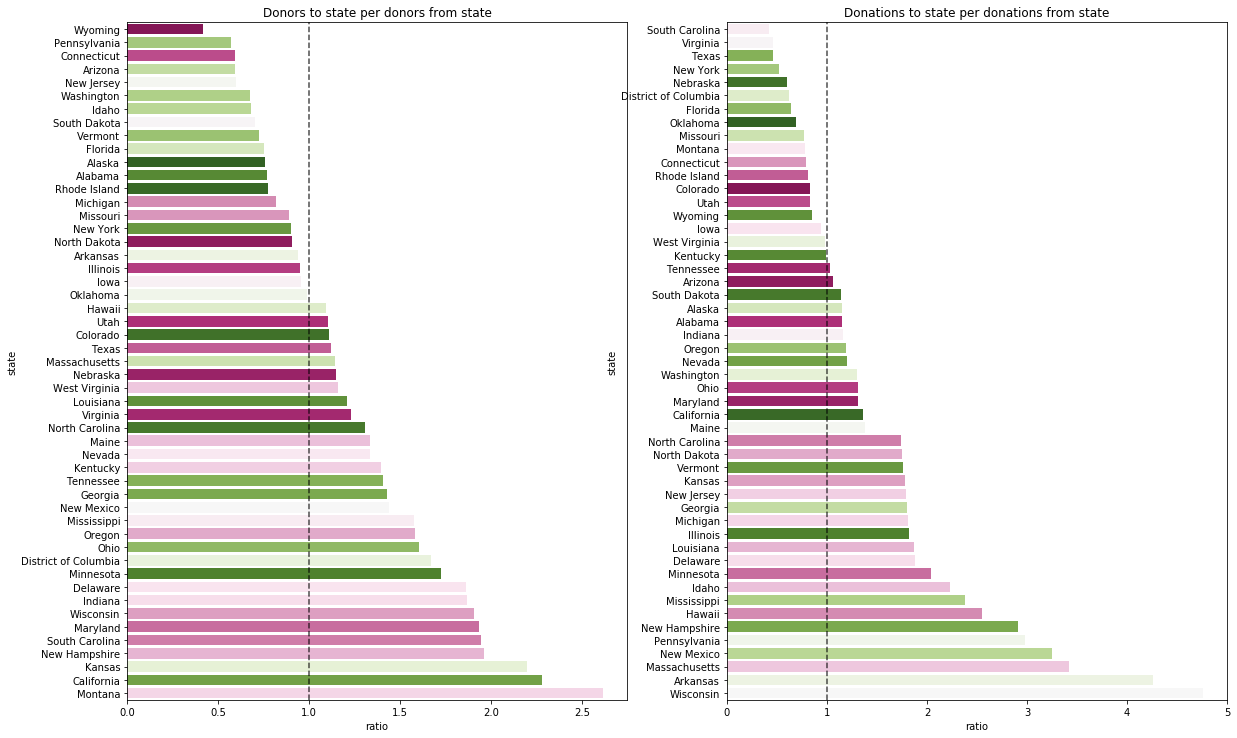

In [60]:
df = pd.DataFrame({'state': state_donor_transfer_mat.columns.values[r1.argsort()[::-1]], 'ratio': r1, 'to_sum': to_sum1}).sort_values('ratio')
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(121)

pal = sns.color_palette("PiYG_r", len(df['to_sum']))
rank = df['to_sum'].argsort().argsort()

ax = sns.barplot(y='state', x='ratio', data=df, orient='h', palette=np.array(pal[::-1])[rank])
#ax.figure.colorbar()
ax.axvline(1, 0, 1, linestyle='--', c='k', alpha=0.7)
plt.title('Donors to state per donors from state')

# ======

df = pd.DataFrame({'state': state_donation_transfer_mat.columns.values[r2.argsort()[::-1]], 'ratio': r2, 'to_sum': to_sum2}).sort_values('ratio')

plt.subplot(122)

pal = sns.color_palette("PiYG_r", len(df['to_sum']))
rank = df['to_sum'].argsort().argsort()

ax = sns.barplot(y='state', x='ratio', data=df, orient='h', palette=np.array(pal[::-1])[rank])
ax.axvline(1, 0, 1, linestyle='--', c='k', alpha=0.7)
plt.title('Donations to state per donations from state');

**Left: x-axis is the ratio of the number of donors donating to that state divided by the number of donors donating from that state (to another state). y-axis is all 51 states (DC included) ordered by x-axis. A ratio of less than one (the top of the y-axis) means that that state has more people donating to it than people donating from it. The color represents the *strength* of the ratio as a measure of the number of people donating to the state. Green means a lot of people donate to the state, pink means not so much. Green bars at the top are good indicators of a state to heavily receives and does not give out many donations to other states.**

**Right is the same as the left except the ratio is a measure of total donations to the state divided by total donations away from that state.**

**I think it's interesting to know which states people love to give to that don't give a whole lot back**

In [115]:
trunc_full_project_donations = full_project_donations.drop(['project_id', 'school_id', 'teacher_id', 'donor_id', 'expire'], axis=1)
trunc_full_project_donations['posted'] = pd.to_datetime(trunc_full_project_donations['posted'], utc=True, unit='s')
trunc_full_project_donations['date'] = pd.to_datetime(trunc_full_project_donations['date'], utc=True, unit='s')

In [117]:
def makeWeekday(a):
    '''
    weekday
    '''
    return a.weekday()

def makeDecimalHour(a):
    '''
    decimal hour
    '''
    return a.hour + (a.minute / 60.0)

trunc_full_project_donations['posted_weekday'] = trunc_full_project_donations['posted'].apply(makeWeekday)
trunc_full_project_donations['date_weekday'] = trunc_full_project_donations['date'].apply(makeWeekday)

trunc_full_project_donations['posted_time'] = trunc_full_project_donations['posted'].apply(makeDecimalHour)
trunc_full_project_donations['date_time'] = trunc_full_project_donations['date'].apply(makeDecimalHour)

trunc_full_project_donations['donate_offset'] = trunc_full_project_donations['date'] - trunc_full_project_donations['posted']

trunc_full_project_donations = trunc_full_project_donations.drop(['posted', 'date'], axis=1)

In [121]:
trunc_full_project_donations['funded'] = trunc_full_project_donations['funded'].apply(lambda f: 0 if np.isnan(f) else 1)

In [122]:
trunc_full_project_donations

,proj_post_seq,proj_type,cat_tree,subcat_tree,grade_level,resource_cat,cost,status,funded,amount,donor_city,donor_state,donor_teacher,donor_zip,posted_weekday,date_weekday,posted_time,date_time,donate_offset
0,18,2,History & Civics,History & Geography,1,Visitors,3044.47,0,1,10.00,Medford,New York,1,117.0,2,3,0.0,8.033333,267 days 08:02:40
1,18,2,History & Civics,History & Geography,1,Visitors,3044.47,0,1,10.00,Medford,New York,1,117.0,2,4,0.0,14.050000,366 days 14:03:06
2,18,2,History & Civics,History & Geography,1,Visitors,3044.47,0,1,10.00,Medford,New York,1,117.0,2,2,0.0,9.333333,343 days 09:20:03
3,12,0,Special Needs,Special Needs,3,Trips,1622.28,0,1,250.00,West Palm Beach,Florida,0,334.0,2,4,0.0,15.516667,366 days 15:31:39
4,12,0,Special Needs,Special Needs,3,Trips,1622.28,0,1,50.00,West Palm Beach,Florida,1,334.0,2,0,0.0,9.366667,229 days 09:22:41
5,7,2,"Literacy & Language, History & Civics","Literature & Writing, Social Sciences",1,Visitors,2774.60,0,1,10.00,Onalaska,Wisconsin,0,546.0,1,1,0.0,23.783333,196 days 23:47:39
6,8,2,"Math & Science, Literacy & Language","Environmental Science, Literature & Writing",1,Books,1086.06,1,0,50.00,Princeton Junction,New Jersey,0,85.0,0,1,0.0,20.750000,120 days 20:45:05
7,5,2,Literacy & Language,"Literacy, Literature & Writing",3,Technology,994.75,1,0,99.75,San Diego,California,0,921.0,0,2,0.0,0.433333,128 days 00:26:58
8,5,2,Literacy & Language,"Literacy, Literature & Writing",3,Technology,994.75,1,0,123.00,Laguna Hills,California,0,926.0,0,2,0.0,23.633333,121 days 23:38:31
9,3,2,Math & Science,"Environmental Science, Mathematics",1,Supplies,384.01,0,1,50.00,Pittsburgh,Ohio,0,152.0,1,1,0.0,12.166667,119 days 12:10:06


can we make a predicition: how much should we suggest this donor donate? depends on how many times they've donated, how much they've already donated, city population, city urban, have been donating to same city. must look at only 1-10 donation donors, want to pick donation amounts that maximize total donations ina  certain group/period